# Optimal Crop Recommendations
#इष्टतम फसल की सिफारिशें



In [138]:
#@markdown **नीचे अपना क्षेत्र चुनें और सिफारिशें प्राप्त करने के लिए बाएं बटन पर क्लिक करें**
#@markdown *Select your area below & Click the left button to get recommendations*

Select_Area = "Bangalore " #@param ["Bangalore ", "Bareilly ", "Bhatinda ", "Coimbatore ", "DehraDun ", "Guwahati ", "Jabalpur ", "Jammu ", "Kolkata ", "Mangalore ", "Mysore ", "Panjim ", "PortBlair ", "Pune ", "Rajkot ", "Ranchi ", "Shimla ", "Srinagar ", "Thiruvananthapuram ", " Varanasi "]
#-----------------------------imports-----------------------------------------#
import csv
import datetime
import sys
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#-----------------------------------------------------------------------------#



#--------------------------variable declaration-------------------------------#
now = datetime.datetime.now()
month=now.month
#month=6 #dummy month for june
area=""
temp=[]
temp_final=[]
rain_fall=[]
rainfall_final=[]
prevtemp=0
prevrainfall=0
#-----------------------------get area function-------------------------------#
# def main(area):
#     area=sys.argv[1]
#     area+=' '
#     #print "this is area:", area
#     return str(area)
#area=main(area)
##For manual state
#area= 'Bangalore '
#state='Maharashtra'
area= Select_Area
#---------------------------nutrient conv function----------------------------#
def conv(nutrient):
    nutrient_dict={'VL':1,'L':2,'M':3,'H':4,'VH':5 }
    return  nutrient_dict.__getitem__(nutrient)

#----------------------------areas temp and rain -----------------------------#
with open('temprainfall.csv') as csvfile:
    #print('this is area:'+area)
    reader = csv.reader(csvfile)
    flag=0
    
    for row in reader:
        #print "this is area:", area
        if row[0] == area:
           #print "this is area:", area
           #print(row)
           if flag==0:
               state=row[1]
               flag=1
           temperature=(float(row[3])+float(row[4]))/2
           temp.append(round(temperature,2))
           rain_fall.append(float(row[5])) 

csvfile.close 
#return state           
#state=temperature()
#-----------------------------------------------------------------------------#




#------------areas temp and rain function acc to users month------------------#
def rainfall(temp_final,rainfall_final,temp,rain_fall):    
    index=month-1
    prevtemp=0
    prevrainfall=0
    
    for i in range (1,13):
        #print prev
        prevtemp=prevtemp+temp[index]
        temp_final.append(round((prevtemp/i),2))
        prevrainfall=prevrainfall+rain_fall[index]
        rainfall_final.append(round(prevrainfall,2))
        index= index+1
        if index==12:
            index=0

#print temp_avg
#print rainfall_final

#-------------------get nutrients of farmers area-----------------------------#
def nutrients(state,rainfall_final,temp_final):
    try:
        #print('this is state:'+state)
        with open('nutrientsarea.csv', 'r') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
               if row[0] == state:
                   narea=conv(row[1])
                   parea=conv(row[2])
                   karea=conv(row[3])
                   ph=row[4]
    except IOError:
       print ("No file exists named nutrientsarea.csv")
       sys.exit("The required file does not exist!!!")               
    csvfile.close

    #nutrient based filter of crops
    try:
        
        with open('cropDB.csv', 'r') as csvfile, open('metacrops.csv', 'w') as metacrops:
            reader = csv.reader(csvfile)
            #writer=csv.writer(metacrops)
            metacrops.writelines("Crop, Rainfall, Temperature, pH \n")
            for row in reader:
               ncrop=conv(row[8])
               pcrop=conv(row[9])
               kcrop=conv(row[10])
               if(narea>=ncrop and parea>=pcrop and karea>=kcrop):
                   #swriter.writerows(row)
                   no_months=int(row[1])
                   #print("this in no months",no_months)
                   total=row[0]+","+str(rainfall_final[no_months-1])+","+str(temp_final[no_months-1])+","+ph+"\n"
                   metacrops.writelines(total)
                   #print total
    except IOError:
       print ("No file exists named cropDB.csv")
       sys.exit("The required file does not exist!!!")     
    csvfile.close
    metacrops.close 
#-----------------------------------------------------------------------------#




#--------------------replicate file with headings--------------------------------#
def filewrite():
    n=1
    try:
        with open("metacrops.csv",'r') as f:
            with open("metacrops11.csv", "w") as f1:
                for line in f:
                    if n==1:
                        n=n+1
                        continue
                    f1.write(line)
    except IOError as e:
            print ("I/O error({0}): {1}".format(e.errno, e.strerror))
            sys.exit("No such file exists")
    f.close
    f1.close  
#-----------------------------------------------------------------------------#



            
#------------------------------MLR function-----------------------------------#                
def regression():
   
# Data Preprocessing 
    n=0
    crop_Y_pred=[]
    crop_name=[]
    dataset=pd.read_csv('regressiondb.csv')
    locbased=pd.read_csv('metacrops.csv')
    
    try:
       with open('metacrops11.csv', 'r') as csvfile:
            reader = csv.reader(csvfile)
            #metacrops.writelines("Crop,Production\n")
            #os.remove('final.txt')
            for row in reader:
               crop=row[0]
        # Importing the dataset
               metadata=dataset.loc[dataset['Crop'] == crop]
               X = metadata.iloc[:, :-2].values
               Y = metadata.iloc[:, 4].values
               
               ##fitting MLR to training set  
               ##regressor = LinearRegression()
               ##regressor.fit(X, Y)
              
               X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0)
               regressor = LinearRegression()
               regressor.fit(X_train, Y_train)  
               
               #predecting test set results
               '''Y_pred_test = regressor.predict(X_test)
               print("this is Y test:", Y_test)
               print "\n"
               print("this is Y predicted:", Y_pred_test) '''
       
               #predecting final set results
               X_locbased = locbased.loc[[n]].values #take all except 0th col that is crop name
               X_locbased = X_locbased[:, 1:4]
               Y_pred=regressor.predict(X_locbased)
               
               if Y_pred>0:
                   crop_Y_pred.append(round(Y_pred[0],3))
                   crop_name.append(crop)
                                     
       #print(crop_name,crop_Y_pred)
       sorted_crops=quicksort(crop_name,crop_Y_pred,0,len(crop_Y_pred)-1)                       
       csvfile.close
       #return pred_crop
       return sorted_crops
   
    except (IOError):
        print ('No file exists named metacrops11.csv')
        sys.exit("No such file exists")
    os.remove('metacrops.csv')       
    os.remove('metacrops11.csv')
#-----------------------------------------------------------------------------#



        
#------------------------------sorting fn-------------------------------------#                   
def quicksort(crop_name,crop_Y_pred,start, end):
    if start < end:
        # partition the list
        pivot = partition(crop_name,crop_Y_pred, start, end)
        # sort both halves
        quicksort(crop_name,crop_Y_pred, start, pivot-1)
        quicksort(crop_name,crop_Y_pred, pivot+1, end)
    return crop_name

#partition function
def partition(crop_name,crop_Y_pred, start, end):
    pivot = crop_Y_pred[start]
    left = start+1
    right = end
    done = False
    while not done:
        while left <= right and crop_Y_pred[left] >= pivot:
            left = left + 1
        while crop_Y_pred[right] <= pivot and right >=left:
            right = right -1
        if right < left:
            done= True
        else:
            # swap places Y_pred
            temp=crop_Y_pred[left]
            crop_Y_pred[left]=crop_Y_pred[right]
            crop_Y_pred[right]=temp
            
            # swap places Y_crop
            temp1=crop_name[left]
            crop_name[left]=crop_name[right]
            crop_name[right]=temp1
            
    # swap start with myList[right]
    temp=crop_Y_pred[start]
    crop_Y_pred[start]=crop_Y_pred[right]
    crop_Y_pred[right]=temp
    
    # swap start with myList[right] for crop 
    temp1=crop_name[start]
    crop_name[start]=crop_name[right]
    crop_name[right]=temp1
        
    return right    
#-----------------------------------------------------------------------------#  




    '''reader = csv.DictReader(open('metasort.csv', 'r'))
    result = sorted(reader, key=lambda d: float(d['Production']),reverse=True)
    writer = csv.DictWriter(open('output.csv', 'w'), reader.fieldnames)
    writer.writeheader()
    writer.writerows(result)   
    import json
    jsonfile=open('sort.json','w')
    jsonfile.write(json.dumps(list(csv.reader(open('output.csv')))))
    os.remove('metacrops.csv')
    os.remove('metacrops11.csv')
'''



#-----------------------conv crop list to string------------------------------#
def ListtoStr(sorted_crop):
    pred_crop = ""
    comma_flag=0
    no=len(sorted_crop)
    if(no>10):
        no=10
    for i in range (no):
        if comma_flag==1:
            pred_crop=pred_crop+","
                       
        pred_crop= pred_crop + sorted_crop[i]
        comma_flag=1
    return pred_crop
#-----------------------------------------------------------------------------#
    



#------------------------code execution begin---------------------------------#
if __name__ == '__main__':

    rainfall(temp_final,rainfall_final,temp,rain_fall)
    nutrients(state,rainfall_final,temp_final)
    filewrite()
    sorted_crop=regression()
    #print(sorted_crop)
    final_crop=ListtoStr(sorted_crop)
    print("Recommended crops for your region are/आपके क्षेत्र के लिए अनुशंसित फसलें हैं :\n")
    print (final_crop)



    
    
    
    
    
    

Recommended crops for your region are/आपके क्षेत्र के लिए अनुशंसित फसलें हैं :

Bottle Gourd,Barley,Guar seed,Orange,Bean,Lentil,Groundnut


Jute


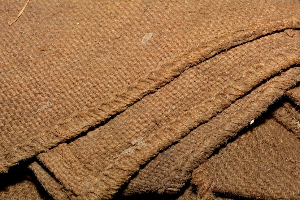

Cardamom


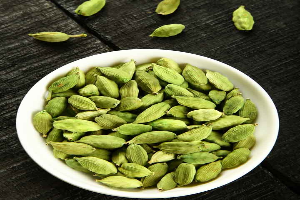

Cauliflower


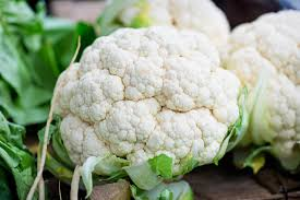

Bottle Gourd


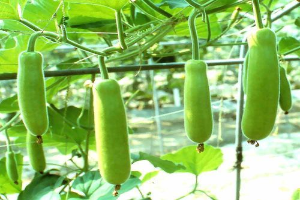

Barley


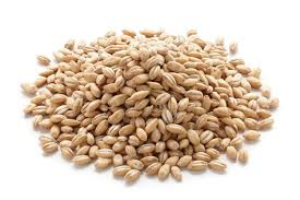

Guar seed


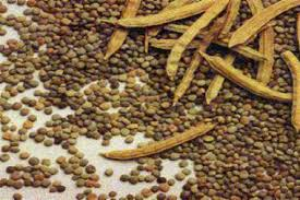

Potato


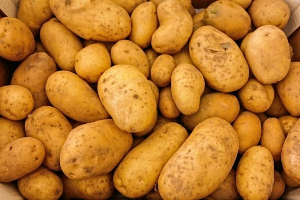

Bean


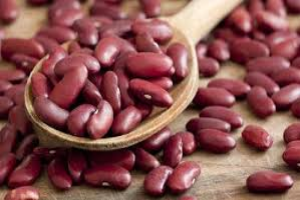

In [136]:
#@markdown **आपके क्षेत्र के लिए अनुशंसित फसलें हैं :**
#@markdown *Recommended crops for your region are: *

##to get and display image
from google.colab.patches import cv2_imshow
import cv2
#!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png 
#img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
#img = cv2.resize(img, (300, 200))
# cv2_imshow(img)
for i in (sorted_crop):
#     if i=='Barley':
#       im = cv2.imread('barley.jpg', cv2.IMREAD_UNCHANGED)
#       #img = cv2.resize(im, (300, 200))
#       cv2_imshow(im)
    s=str(i)+'.jpg'
    print(str(i))
    im = cv2.imread(s, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(im, (300, 200))
    cv2_imshow(img)
    
  
  
    

# Explanation
#स्पष्टीकरण
---

English:

> This module predicts the most profitable & suitable crop in a given area for the current weather and soil conditions. Thus it provides a farmer with variety of options of crops that can be cultivated.




---
हिंदी:

> यह प्रणाली वर्तमान मौसम और मिट्टी की स्थिति के लिए किसी क्षेत्र में सबसे अधिक लाभदायक और उपयुक्त फसल की भविष्यवाणी करती है। इस प्रकार यह एक किसान को फसलों के विभिन्न प्रकार के विकल्प प्रदान करता है जिनकी खेती की जा सकती है।


---

